In [10]:
import numpy as np
import cv2, math, time
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

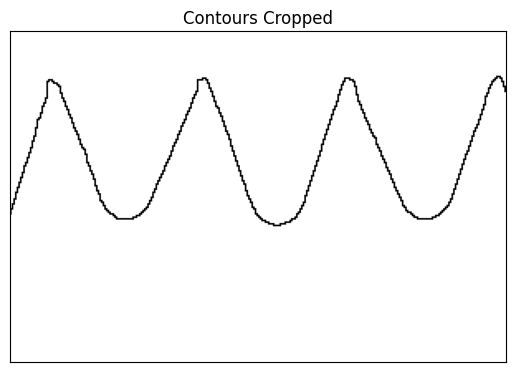

In [11]:
img = cv2.imread("Images\saw_01.png", 0)

ret,img_thresholded = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

kernel = np.ones((3,3),np.uint8)
img_contours = img_thresholded - cv2.erode(img_thresholded, kernel)     # Contours are white, background is black
img_contours_negative = 255 - img_contours                              # Contours are black, background is white

img_cc = img_contours_negative[400:600,:290]
plt.imshow(img_cc, cmap = 'gray')
plt.title('Contours Cropped')
plt.xticks([]), plt.yticks([])
plt.show()
#cv2.imwrite("Images\saw_01_contours_cropped.png", img_cc)
raw_contour = [[i,j] for i in range(img_cc.shape[0]) for j in range(img_cc.shape[1]) if img_cc[i,j] == 0]

In [12]:
## Gif of the contours being drawn, order of the points drawn is the order of the list raw_contours (from top to bottom)
#blank = np.ones((img_cc.shape[0], img_cc.shape[1]), np.uint8) * 255
#for i in raw_contours:
#    blank[i[0], i[1]] = 0
#    cv2.imshow('image', blank)
#    cv2.waitKey(1)
#
#cv2.waitKey(0)    
#cv2.destroyAllWindows()

In [13]:
# TODO: OPTIMIZE THIS FUNCTION
def sort_contour_points2(points, neighborhood_dimension=10):
    sorted_points = sorted(points, key=lambda p: p[1])
    sorted_contour = [sorted_points[0]]
    sorted_points.remove(sorted_points[0])    
    
    work_point = sorted_contour[0]
    start_index = 0

    while sorted_points:
        if len(sorted_points) > start_index + neighborhood_dimension:
            end_index = start_index + neighborhood_dimension
            euclidean_distances = [((work_point[0] - p[0]) ** 2 + (work_point[1] - p[1]) ** 2) for p in sorted_points[:end_index]]
        else:
            euclidean_distances = [((work_point[0] - p[0]) ** 2 + (work_point[1] - p[1]) ** 2) for p in sorted_points]    

        min_distance = min(euclidean_distances)
        nearest_neighbors = [i for i in range(len(euclidean_distances)) if euclidean_distances[i] == min_distance]

        work_point = sorted_points[nearest_neighbors[0]]
        start_index = sorted_points.index(work_point)

        #if len(nearest_neighbors) > 1:
        #    print("Work point:", work_point,"index:", start_index)
        #    print(nearest_neighbors, "\n")

        for i in nearest_neighbors:
            sorted_contour.append(sorted_points[i])

        for i in sorted(nearest_neighbors, reverse=True):
            sorted_points.remove(sorted_points[i])
            
    return sorted_contour

#sorted_contour = sort_contour_points2(raw_contour, neighborhood_dimension=20)

In [14]:
def sort_contour_points(points):
    sorted_points = sorted(points, key=lambda p: p[1])
    sorted_contour = [sorted_points[0]]
    sorted_points.remove(sorted_points[0])    
    work_point = sorted_contour[0]

    while sorted_points:
        euclidean_distances = [((work_point[0] - p[0]) ** 2 + (work_point[1] - p[1]) ** 2) for p in sorted_points]
        
        min_distance = min(euclidean_distances)
        nearest_neighbors = [i for i in range(len(euclidean_distances)) if euclidean_distances[i] == min_distance]

        work_point = sorted_points[nearest_neighbors[0]]

        for i in nearest_neighbors:
            sorted_contour.append(sorted_points[i])

        for i in sorted(nearest_neighbors, reverse=True):
            sorted_points.remove(sorted_points[i])
                    
    return sorted_contour

'''
Why has been necessary to sort the points of the contour?
    - The contour is a list of points that are not ordered in any way, so the first step is to order them in a way that
    makes sense. The order of the points is important because it will be used to calculate the angle between each pair of
    points, and the angle is the most important feature of the contour.
Why has been necessary to use the euclidean distance to sort the points?
    - The euclidean distance is used to find the nearest neighbor of a point, and it is used because it is the most
    straightforward way to find the nearest neighbor of a point in a 2D space.
Why has been necessary to use the nearest neighbors?
    - Because the nearest neighbors of a point are the next points in the contour, and it is important to find the nearest
    neighbors of a point to order the contour. 
'''

sorted_contour = sort_contour_points(raw_contour)

In [15]:
## Gif of the contours being drawn, order of the points drawn is the order of the list sorted_contour (from left to right)
#blank = np.ones((img_cc.shape[0], img_cc.shape[1]), np.uint8) * 255
#for i in sorted_contour:
#    blank[i[0], i[1]] = 0
#    cv2.imshow('image', blank)
#    cv2.waitKey(1)
#
#cv2.waitKey(0)    
#cv2.destroyAllWindows()

In [16]:
def RDP_Algorithm(points, epsilon):
    # get the start and end points
    start = points[0]
    end = points[-1]

    # find distance from other points to line formed by start and end
    dist_point_to_line = DPTL(points, start, end)

    # get the index of the points with the largest distance
    max_value = max(dist_point_to_line)
    max_idx = dist_point_to_line.index(max_value) + 1 #since the first (and the last point) are not included in the calculation

    result = []
    if max_value > epsilon:
        if len(points[:max_idx+1]) == 2:
            result += [list(i) for i in points[:max_idx+1] if list(i) not in result]
        else:
            partial_results_left = RDP_Algorithm(points[:max_idx+1], epsilon)
            result += [list(i) for i in partial_results_left if list(i) not in result]
        if len(points[max_idx:]) == 2:
            result += [list(i) for i in points[max_idx:] if list(i) not in result]
        else:
            partial_results_right = RDP_Algorithm(points[max_idx:], epsilon)
            result += [list(i) for i in partial_results_right if list(i) not in result]
    else:
        result += [points[0], points[-1]]
    
    return result

def DPTL(points, start, end):
    # return a list of distances: distance of each point in points to line formed by start and end

    # compute the angular coefficient and the constant of the line formed by start and end
    # y - mx - q = 0
    a = start[1] - end[1]
    b = end[0] - start[0]
    c = - a*start[0] - b*start[1] 

    return [abs(a*points[i][0]+b*points[i][1]+c)/(math.sqrt(a**2+b**2)) for i in range(1,len(points))]

In [17]:
simplified_contour = RDP_Algorithm(sorted_contour, epsilon = 3)

blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
for i in range(len(simplified_contour)):
    blank[simplified_contour[i][0], simplified_contour[i][1]] = [0,0,255]
cv2.imwrite("Images\saw_01_simplified_contours.png", blank)

def distance(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

def segment_contours(points, threshold, min_points):
    segments = []
    i = 0
    while i < len(points):
        close_points = [points[i]]
        for j in range(i,len(points)-1):
            if distance(points[j], points[j+1]) < threshold:
                close_points.append(points[j+1])
            else:
                break
        if len(close_points) >= min_points:
            segments.append(close_points)
            i += len(close_points)
        else:
            segments.append([points[i]])
            i += 1
    return segments

def extract_circular_arcs(segement_points, sorted_contour):
    circular_arcs = []
    for i in segement_points:
        if len(i) > 1:
            circular_arcs.append(sorted_contour[sorted_contour.index(i[0]):sorted_contour.index(i[-1])])
    return circular_arcs

def extract_straight_lines(segement_points):
    straight_lines = []
    start_index = 0
    for i in segement_points:
        if len(i) > 1:
            end_index = sorted_contour.index(i[0])
            straight_lines.append(sorted_contour[start_index:end_index])
            start_index = sorted_contour.index(i[-1])
    end_index = len(sorted_contour)
    straight_lines.append(sorted_contour[start_index:end_index])
    return straight_lines


segmented_contour = segment_contours(simplified_contour, threshold=31.5, min_points=4)
blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
for i in extract_circular_arcs(segmented_contour, sorted_contour):
    for j in i:
        blank[j[0], j[1]] = [0,0,255]
cv2.imwrite("Images\saw_01_circular_arcs.png", blank)

blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
for i in extract_straight_lines(segmented_contour):
    for j in i:
        blank[j[0], j[1]] = [0,255,0]
cv2.imwrite("Images\saw_01_straight_lines.png", blank)

#arcs = extract_circular_arcs(segmented_contour, sorted_contour)
#circ_arcs = [j for i in arcs for j in i]
#segmented_contour = segment_contours(simplified_contour, threshold=31.5, min_points=4)
#blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
#st_lines = [i for i in sorted_contour if i not in circ_arcs]
#for i in st_lines:
#        blank[i[0], i[1]] = [255,0,0]
#cv2.imwrite("Images\saw_01_straight_lines.png", blank)

True

In [18]:
def fit_triangle(points1, points2):
    line1 = np.polyfit([p[0] for p in points1], [p[1] for p in points1], 1)
    line2 = np.polyfit([p[0] for p in points2], [p[1] for p in points2], 1)

    x_intersect = (line2[1] - line1[1]) / (line1[0] - line2[0])
    y_intersect = line1[0] * x_intersect + line1[1]

    return (x_intersect, y_intersect)